# Using the method from the Deep learning class to process the iris dataset

In [235]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math

----
## Loading and preparing the data

In [236]:
# loading the data
train_data= pd.read_csv("iris_training.csv")
test_data= pd.read_csv("iris_test.csv")

In [237]:
# transposing the data to have dimensions (features, m)
train_df= train_data.transpose()
test_df= test_data.transpose()
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
sepal length,6.4,5.0,4.9,4.9,5.7,4.4,5.4,6.9,6.7,5.1,...,6.3,5.7,5.0,6.3,5.0,5.5,5.7,4.4,4.8,5.5
sepal width,2.8,2.3,2.5,3.1,3.8,3.2,3.4,3.1,3.1,3.7,...,2.7,2.8,3.0,3.3,3.5,2.6,3.0,2.9,3.0,2.4
petal length,5.6,3.3,4.5,1.5,1.7,1.3,1.5,5.1,4.4,1.5,...,4.9,4.1,1.6,6.0,1.6,4.4,4.2,1.4,1.4,3.7
petal width,2.2,1.0,1.7,0.1,0.3,0.2,0.4,2.3,1.4,0.4,...,1.8,1.3,0.2,2.5,0.6,1.2,1.2,0.2,0.1,1.0
class,2.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,...,2.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0


In [238]:
# separating the data into features and labels
X_train= train_df.drop(["class"])
y_train= train_data["class"]
X_test= test_df.drop(["class"])
y_test= test_data["class"]

### Converting X into numpy.ndarray

In [239]:
X_train= X_train.values
X_test= X_test.values

### One-hot encoding of y_train and y_test
Many times in deep learning you will have a y vector with numbers ranging from 0 to C-1, where C is the number of classes.

In [240]:
def one_hot_matrix(labels, C):
    # Create a tf.constant equal to C (depth)
    C = tf.constant(C, name="C")

    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, depth=C, axis=0)
    
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
    
    return one_hot

In [241]:
Y_train= one_hot_matrix(y_train, C=3)
Y_test= one_hot_matrix(y_test, C=3)

----
## Creating placeholders for X and Y
This will allow us to later pass our training data in when we run our session.

In [242]:
def create_placeholders(n_x, n_y):
    #n_x -- scalar, number of features
    #n_y -- scalar, number of classes
    
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X, Y

----
## Initializing the parameters/weigths W and b
We are going to use Xavier Initialization for weights and Zero Initialization for biases. We're going to build a 3-layer NN with 4 units in the hidden layers and 3 units in the output layer (since we have 3 different classes). The shapes are therefore the following:
- W1 and W2: [4,4]
- b1 and b2: [4,1]
- W3: [3,4]
- b3: [3,1]

In [243]:
def initialize_parameters():
    
    tf.set_random_seed(1)    
    W1 = tf.get_variable("W1", [4,4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [4,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [4,4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [4,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [3,4], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

----
## Defining mini-batches

In [244]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
        
    # shuffling (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]  #.reshape((3,m))

    # partitioning (minus the end case)
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : m+1]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : m+1]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

----
## Implementing forward prop
Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

In [245]:
def forward_propagation(X, parameters):
    # Retrieving parameters 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # implementing forward prop
    Z1 = tf.add( tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add( tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add( tf.matmul(W3, A2), b3)
    return Z3

----
## Computing the cost

It is important to know that the "logits" and "labels" inputs of tf.nn.softmax_cross_entropy_with_logits are expected to be of shape (number of examples, num_classes). We therefore need to **transpose Z3 and Y**.

In [246]:
def compute_cost(Z3, Y):
    # transposing Z3 and Y to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    
    return cost

----
## Backprop and parameter updates
All the backpropagation and the parameters update is taken care of in 1 line of code thanks to Tensorflow.

----
## Building the model

In [247]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
 
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    # creating placeholders
    X, Y = create_placeholders(n_x, n_y)

    # initializing parameters
    parameters = initialize_parameters()

    # Forward prop
    Z3 = forward_propagation(X, parameters)
    
    # adding cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # backprop: defining the tensorflow optimizer (AdamOptimizer)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()


    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed+1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # saving the parameters in a variable
        parameters = sess.run(parameters)

        # calculating correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # calculating accuracy on the TEST set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.662236
Cost after epoch 100: 0.339344
Cost after epoch 200: 0.180884
Cost after epoch 300: 0.104010
Cost after epoch 400: 0.084618
Cost after epoch 500: 0.078849
Cost after epoch 600: 0.072751
Cost after epoch 700: 0.060619
Cost after epoch 800: 0.058437
Cost after epoch 900: 0.055720


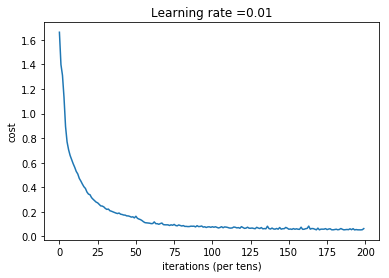

Train Accuracy: 0.983333
Test Accuracy: 0.966667


In [248]:
parameters = model(X_train, Y_train, X_test, Y_test)